In [42]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing
from sklearn.utils import shuffle

In [43]:
# 把所有年份的資料merge在一起,並存在data.csv裡
def mergeData():
    SaveFile_Name = 'data.csv'
    file_list = os.listdir('data')
    df = pd.read_csv('data'+'\\'+file_list[0])
    df.to_csv(SaveFile_Name,encoding="utf_8_sig",index=False)
    for i in range(1,len(file_list)):
        df = pd.read_csv('data'+'\\'+file_list[i])
        df.to_csv(SaveFile_Name,encoding="utf_8_sig",index=False, header=False, mode='a+')

In [44]:
# 讀取data.csv
def readData():
    train = pd.read_csv("data.csv")
    return train

In [45]:
# 把年份換成西元年
def changeYear(data):
    for i in range(0,data.shape[0]):
        Date=data["日期"][i].split('/')
        year,month,date=Date[0],Date[1],Date[2]
        year=str(int(year)+1911)
        data.loc[i,"日期"]=year+'/'+month+'/'+date
    return data

In [46]:
# 增加features("年","月","日","第幾日")
def augFeatures(data):
  data["日期"] = pd.to_datetime(data["日期"])
  data["年"] = data["日期"].dt.year
  data["月"] = data["日期"].dt.month
  data["日"] = data["日期"].dt.day
  data["第幾日"] = data["日期"].dt.dayofweek
  return data

In [47]:
# 把非數字的資料換成正確資料,並減少features("日期","成交股數","成交金額",等等...)
def manage(data):
    for i in range(0,data.shape[0]):
        if data["漲跌價差"][i]=='X0.00':
            data.loc[i,"漲跌價差"]=str(int(data["收盤價"][i])-int(data["收盤價"][i-1]))
    data=data.drop(["日期"], axis=1)
    data=data.drop(["成交股數"], axis=1)
    data=data.drop(["成交金額"], axis=1)
    data=data.drop(["漲跌價差"], axis=1)
    data=data.drop(["成交筆數"], axis=1)
    data=data.convert_objects(convert_numeric=True)
    return data

In [48]:
# 把資料normalize
def normalize(train):
    train = train.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
    return train

In [49]:
# 創造出train的資料,train_x為輸入資料(所有features),train_y為輸出資料(開盤價的成長率,分為9個區段)
def buildTrain(train, pastDay=30, futureDay=1):
    X_train, Y_train, Z_train= [], [], []
    X,Y,Z=[],[],[]
    for i in range(train.shape[0]-futureDay-pastDay):
        X_train.append(np.array(train.iloc[i:i+pastDay]))
        Y_train.append(np.array(train.iloc[i+pastDay:i+pastDay+futureDay]["開盤價"]))
        Z_train.append(np.array(train.iloc[i+pastDay-1:i+pastDay]["開盤價"]))
    X=np.array(X_train)
    Y=np.array(Y_train)
    Z=np.array(Z_train)
    Y=100*((Y-Z)/Z)
    Y_train=[]
    
    for i in range(len(Y)):
        if Y[i]<-3.5:
            Y_train.append(np.array([0]))
        elif -3.5<=Y[i]<-2.5:
            Y_train.append(np.array([1]))
        elif -2.5<=Y[i]<-1.5:
            Y_train.append(np.array([2]))
        elif -1.5<=Y[i]<-0.5:
            Y_train.append(np.array([3]))
        elif -0.5<=Y[i]<0.5:
            Y_train.append(np.array([4]))
        elif 0.5<=Y[i]<1.5:
            Y_train.append(np.array([5]))
        elif 1.5<=Y[i]<2.5:
            Y_train.append(np.array([6]))
        elif 2.5<=Y[i]<3.5:
            Y_train.append(np.array([7]))
        elif 3.5<=Y[i]:
            Y_train.append(np.array([8]))
    Y=np.array(Y_train)
    
    return X, Y

In [50]:
# 把資料打亂
def shuffle(X,Y):
    np.random.seed()
    randomList = np.arange(X.shape[0])
    np.random.shuffle(randomList)
    return X[randomList], Y[randomList]

In [51]:
# 將資料分成訓練資料和測試資料
def splitData(X,Y,rate):
    X_train = X[:-int(X.shape[0]*rate)]

    Y_train = Y[:-int(Y.shape[0]*rate)]
    
    X_val = X[-int(X.shape[0]*rate):]

    Y_val = Y[-int(Y.shape[0]*rate):]
    return X_train, Y_train, X_val, Y_val

In [52]:
# 建立模型
def buildModel(shape):
    model = Sequential()
    model.add(Dense(250, input_dim=shape[1]))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(250))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(9))
    model.add(Activation('softmax'))
    model.compile(loss="categorical_crossentropy", optimizer='adam',metrics=['accuracy'])
    model.summary()
    return model

In [53]:
import matplotlib.pyplot as plt
import keras
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}
 
    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))
 
    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))
 
    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()


In [71]:
mergeData()
train=readData()
train=changeYear(train)
train=augFeatures(train)
train=manage(train)
train=train.drop(["最高價"], axis=1)
train=train.drop(["最低價"], axis=1)
train=train.drop(["收盤價"], axis=1)
train=train.drop(["年"], axis=1)
train=train.drop(["月"], axis=1)
train=train.drop(["日"], axis=1)
train=train.drop(["第幾日"], axis=1)
temp=train
train=normalize(train)
train_x1, train_y1 = buildTrain(train,1,1)
train_x2, train_y2 = buildTrain(temp,1,1)
train_x1= np.reshape(train_x1, (train_x1.shape[0],train_x1.shape[2]))
train_x, train_y = train_x1,train_y2 
train_y=np_utils.to_categorical(train_y)
train_x, train_y = shuffle(train_x, train_y )
train_x, train_y , test_x, test_y = splitData(train_x, train_y , 0.1)
history = LossHistory()
model = buildModel(train_x.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model.fit(train_x, train_y, epochs=300, batch_size=128, verbose=2,validation_split=0.1, callbacks=[callback,history])


C:\Users\admin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  # This is added back by InteractiveShellApp.init_path()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 250)               500       
_________________________________________________________________
activation_31 (Activation)   (None, 250)               0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 250)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 250)               62750     
_________________________________________________________________
activation_32 (Activation)   (None, 250)               0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 250)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 9)                 2259      
__________

Epoch 81/300
 - 0s - loss: 2.0032 - acc: 0.2394 - val_loss: 1.9824 - val_acc: 0.2509
Epoch 82/300
 - 0s - loss: 2.0039 - acc: 0.2382 - val_loss: 1.9821 - val_acc: 0.2581
Epoch 83/300
 - 0s - loss: 2.0021 - acc: 0.2376 - val_loss: 1.9839 - val_acc: 0.2509
Epoch 84/300
 - 0s - loss: 2.0036 - acc: 0.2400 - val_loss: 1.9832 - val_acc: 0.2652
Epoch 85/300
 - 0s - loss: 2.0035 - acc: 0.2376 - val_loss: 1.9785 - val_acc: 0.2473
Epoch 86/300
 - 0s - loss: 2.0034 - acc: 0.2382 - val_loss: 1.9862 - val_acc: 0.2563
Epoch 00086: early stopping


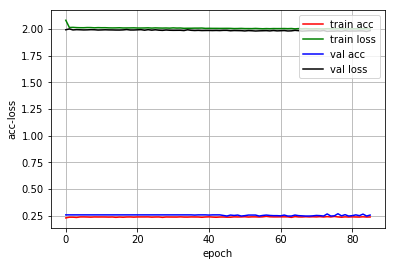

618/618 [==============================] - 0s 36us/step
test loss:  2.0273482722371914
test accuracy:  0.23139158595341308


In [72]:
history.loss_plot('epoch')
loss_1, accuracy_1 = model.evaluate(test_x, test_y)
print('test loss: ', loss_1)
print('test accuracy: ', accuracy_1)

In [73]:
mergeData()
train=readData()
train=changeYear(train)
train=augFeatures(train)
train=manage(train)
train=train.drop(["最高價"], axis=1)
train=train.drop(["最低價"], axis=1)
train=train.drop(["收盤價"], axis=1)
temp=train
train=normalize(train)
train_x1, train_y1 = buildTrain(train,1,1)
train_x2, train_y2 = buildTrain(temp,1,1)
train_x1= np.reshape(train_x1, (train_x1.shape[0],train_x1.shape[2]))
train_x, train_y = train_x1,train_y2 
train_y=np_utils.to_categorical(train_y)
train_x, train_y = shuffle(train_x, train_y )
train_x, train_y , test_x, test_y = splitData(train_x, train_y , 0.1)
history = LossHistory()
model = buildModel(train_x.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model.fit(train_x, train_y, epochs=300, batch_size=128, verbose=2,validation_split=0.1, callbacks=[callback,history])

C:\Users\admin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  # This is added back by InteractiveShellApp.init_path()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 250)               1500      
_________________________________________________________________
activation_34 (Activation)   (None, 250)               0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 250)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 250)               62750     
_________________________________________________________________
activation_35 (Activation)   (None, 250)               0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 250)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 9)                 2259      
__________

Epoch 81/300
 - 0s - loss: 1.8751 - acc: 0.2837 - val_loss: 1.9750 - val_acc: 0.2437
Epoch 82/300
 - 0s - loss: 1.8724 - acc: 0.2871 - val_loss: 1.9810 - val_acc: 0.2330
Epoch 83/300
 - 0s - loss: 1.8690 - acc: 0.2879 - val_loss: 1.9779 - val_acc: 0.2401
Epoch 84/300
 - 0s - loss: 1.8705 - acc: 0.2918 - val_loss: 1.9806 - val_acc: 0.2348
Epoch 85/300
 - 0s - loss: 1.8677 - acc: 0.2918 - val_loss: 1.9782 - val_acc: 0.2366
Epoch 86/300
 - 0s - loss: 1.8691 - acc: 0.2892 - val_loss: 1.9766 - val_acc: 0.2294
Epoch 87/300
 - 0s - loss: 1.8647 - acc: 0.2938 - val_loss: 1.9832 - val_acc: 0.2330
Epoch 88/300
 - 0s - loss: 1.8691 - acc: 0.2845 - val_loss: 1.9800 - val_acc: 0.2258
Epoch 89/300
 - 0s - loss: 1.8702 - acc: 0.2877 - val_loss: 1.9861 - val_acc: 0.2366
Epoch 90/300
 - 0s - loss: 1.8632 - acc: 0.2900 - val_loss: 1.9834 - val_acc: 0.2330
Epoch 91/300
 - 0s - loss: 1.8706 - acc: 0.2871 - val_loss: 1.9821 - val_acc: 0.2348
Epoch 92/300
 - 0s - loss: 1.8616 - acc: 0.2869 - val_loss: 1.980

Epoch 177/300
 - 0s - loss: 1.7952 - acc: 0.3130 - val_loss: 2.0084 - val_acc: 0.2366
Epoch 178/300
 - 0s - loss: 1.7976 - acc: 0.3142 - val_loss: 2.0075 - val_acc: 0.2455
Epoch 179/300
 - 0s - loss: 1.7913 - acc: 0.3196 - val_loss: 2.0175 - val_acc: 0.2258
Epoch 180/300
 - 0s - loss: 1.7990 - acc: 0.3168 - val_loss: 2.0113 - val_acc: 0.2186
Epoch 181/300
 - 0s - loss: 1.7938 - acc: 0.3184 - val_loss: 2.0093 - val_acc: 0.2348
Epoch 182/300
 - 0s - loss: 1.7908 - acc: 0.3214 - val_loss: 2.0103 - val_acc: 0.2366
Epoch 183/300
 - 0s - loss: 1.7917 - acc: 0.3214 - val_loss: 2.0129 - val_acc: 0.2401
Epoch 184/300
 - 0s - loss: 1.7879 - acc: 0.3200 - val_loss: 2.0144 - val_acc: 0.2348
Epoch 185/300
 - 0s - loss: 1.7899 - acc: 0.3218 - val_loss: 2.0193 - val_acc: 0.2168
Epoch 186/300
 - 0s - loss: 1.7902 - acc: 0.3212 - val_loss: 2.0123 - val_acc: 0.2204
Epoch 187/300
 - 0s - loss: 1.7818 - acc: 0.3258 - val_loss: 2.0098 - val_acc: 0.2366
Epoch 188/300
 - 0s - loss: 1.7785 - acc: 0.3202 - val

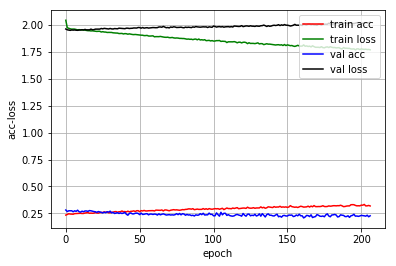

618/618 [==============================] - 0s 34us/step
test loss:  2.009730234115255
test accuracy:  0.22977346287961917


In [74]:
history.loss_plot('epoch')
loss_2, accuracy_2 = model.evaluate(test_x, test_y)
print('test loss: ', loss_2)
print('test accuracy: ', accuracy_2)

In [58]:
mergeData()
train=readData()
train=changeYear(train)
train=augFeatures(train)
train=manage(train)
train=train.drop(["最高價"], axis=1)
train=train.drop(["最低價"], axis=1)
temp=train
train=normalize(train)
train_x1, train_y1 = buildTrain(train,1,1)
train_x2, train_y2 = buildTrain(temp,1,1)
train_x1= np.reshape(train_x1, (train_x1.shape[0],train_x1.shape[2]))
train_x, train_y = train_x1,train_y2 
train_y=np_utils.to_categorical(train_y)
train_x, train_y = shuffle(train_x, train_y )
train_x, train_y , test_x, test_y = splitData(train_x, train_y , 0.1)
history = LossHistory()
model = buildModel(train_x.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model.fit(train_x, train_y, epochs=300, batch_size=128, verbose=2,validation_split=0.1, callbacks=[callback,history])

C:\Users\admin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  # This is added back by InteractiveShellApp.init_path()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 250)               1750      
_________________________________________________________________
activation_19 (Activation)   (None, 250)               0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 250)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 250)               62750     
_________________________________________________________________
activation_20 (Activation)   (None, 250)               0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 250)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 9)                 2259      
__________

Epoch 81/300
 - 0s - loss: 1.8239 - acc: 0.2982 - val_loss: 1.9545 - val_acc: 0.2706
Epoch 82/300
 - 0s - loss: 1.8185 - acc: 0.3102 - val_loss: 1.9500 - val_acc: 0.2760
Epoch 83/300
 - 0s - loss: 1.8125 - acc: 0.3040 - val_loss: 1.9346 - val_acc: 0.2885
Epoch 84/300
 - 0s - loss: 1.8052 - acc: 0.3090 - val_loss: 1.9379 - val_acc: 0.2652
Epoch 85/300
 - 0s - loss: 1.8110 - acc: 0.3078 - val_loss: 1.9286 - val_acc: 0.2796
Epoch 86/300
 - 0s - loss: 1.8028 - acc: 0.3036 - val_loss: 1.9244 - val_acc: 0.2742
Epoch 87/300
 - 0s - loss: 1.7945 - acc: 0.3122 - val_loss: 1.9257 - val_acc: 0.2796
Epoch 88/300
 - 0s - loss: 1.7973 - acc: 0.3150 - val_loss: 1.9193 - val_acc: 0.2796
Epoch 89/300
 - 0s - loss: 1.7864 - acc: 0.3198 - val_loss: 1.9241 - val_acc: 0.2670
Epoch 90/300
 - 0s - loss: 1.7896 - acc: 0.3180 - val_loss: 1.9066 - val_acc: 0.2778
Epoch 91/300
 - 0s - loss: 1.7734 - acc: 0.3230 - val_loss: 1.9104 - val_acc: 0.2814
Epoch 92/300
 - 0s - loss: 1.7736 - acc: 0.3158 - val_loss: 1.896

Epoch 177/300
 - 0s - loss: 1.4926 - acc: 0.4219 - val_loss: 1.6837 - val_acc: 0.3530
Epoch 178/300
 - 0s - loss: 1.4990 - acc: 0.4207 - val_loss: 1.7036 - val_acc: 0.3369
Epoch 179/300
 - 0s - loss: 1.5219 - acc: 0.4097 - val_loss: 1.7317 - val_acc: 0.3315
Epoch 180/300
 - 0s - loss: 1.4972 - acc: 0.4153 - val_loss: 1.6934 - val_acc: 0.3566
Epoch 181/300
 - 0s - loss: 1.4954 - acc: 0.4197 - val_loss: 1.7184 - val_acc: 0.3387
Epoch 182/300
 - 0s - loss: 1.4897 - acc: 0.4285 - val_loss: 1.7006 - val_acc: 0.3656
Epoch 183/300
 - 0s - loss: 1.4946 - acc: 0.4213 - val_loss: 1.6880 - val_acc: 0.3728
Epoch 184/300
 - 0s - loss: 1.4913 - acc: 0.4225 - val_loss: 1.7363 - val_acc: 0.3244
Epoch 185/300
 - 0s - loss: 1.4796 - acc: 0.4229 - val_loss: 1.7030 - val_acc: 0.3566
Epoch 186/300
 - 0s - loss: 1.4837 - acc: 0.4235 - val_loss: 1.6877 - val_acc: 0.3513
Epoch 187/300
 - 0s - loss: 1.4817 - acc: 0.4253 - val_loss: 1.6872 - val_acc: 0.3728
Epoch 188/300
 - 0s - loss: 1.4801 - acc: 0.4299 - val

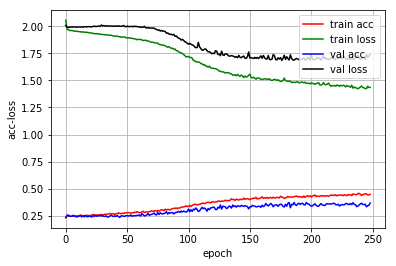

618/618 [==============================] - 0s 39us/step
test loss:  1.6765105419560158
test accuracy:  0.3220064725401332


In [59]:
history.loss_plot('epoch')
loss_3, accuracy_3 = model.evaluate(test_x, test_y)
print('test loss: ', loss_3)
print('test accuracy: ', accuracy_3)

In [60]:
mergeData()
train=readData()
train=changeYear(train)
train=augFeatures(train)
train=manage(train)
temp=train
train=normalize(train)
train_x1, train_y1 = buildTrain(train,1,1)
train_x2, train_y2 = buildTrain(temp,1,1)
train_x1= np.reshape(train_x1, (train_x1.shape[0],train_x1.shape[2]))
train_x, train_y = train_x1,train_y2 
train_y=np_utils.to_categorical(train_y)
train_x, train_y = shuffle(train_x, train_y )
train_x, train_y , test_x, test_y = splitData(train_x, train_y , 0.1)
print(train)
history = LossHistory()
model = buildModel(train_x.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model.fit(train_x, train_y, epochs=300, batch_size=128, verbose=2,validation_split=0.1, callbacks=[callback,history])


C:\Users\admin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  # This is added back by InteractiveShellApp.init_path()


           開盤價       最高價       最低價       收盤價         年         月         日  \
0    -0.021496 -0.026024 -0.017142 -0.021671 -0.499051  0.209821 -0.359942   
1     0.006401  0.001969  0.011417  0.006540 -0.499051  0.209821 -0.326609   
2     0.036444  0.032116  0.042173  0.036922 -0.499051  0.209821 -0.293275   
3     0.068632  0.064416  0.075126  0.069475 -0.499051  0.209821 -0.259942   
4     0.102967  0.098869  0.110275  0.104197 -0.499051  0.209821 -0.226609   
5     0.139448  0.135475  0.147621  0.141089 -0.499051  0.209821 -0.193275   
6     0.178074  0.174235  0.187164  0.180152 -0.499051  0.209821 -0.126609   
7     0.218847  0.215148  0.228904  0.221384 -0.499051  0.209821 -0.093275   
8     0.261765  0.258214  0.272841  0.264787 -0.499051  0.209821 -0.059942   
9     0.308976  0.305587  0.286022  0.312530 -0.499051  0.209821 -0.026609   
10    0.308976  0.322814  0.299203  0.303850 -0.499051  0.209821  0.006725   
11    0.300392  0.314200  0.303597  0.303850 -0.499051  0.209821

Epoch 12/300
 - 0s - loss: 1.9543 - acc: 0.2476 - val_loss: 1.9752 - val_acc: 0.2599
Epoch 13/300
 - 0s - loss: 1.9500 - acc: 0.2484 - val_loss: 1.9762 - val_acc: 0.2384
Epoch 14/300
 - 0s - loss: 1.9485 - acc: 0.2511 - val_loss: 1.9775 - val_acc: 0.2437
Epoch 15/300
 - 0s - loss: 1.9476 - acc: 0.2517 - val_loss: 1.9789 - val_acc: 0.2419
Epoch 16/300
 - 0s - loss: 1.9475 - acc: 0.2527 - val_loss: 1.9783 - val_acc: 0.2366
Epoch 17/300
 - 0s - loss: 1.9446 - acc: 0.2555 - val_loss: 1.9807 - val_acc: 0.2419
Epoch 18/300
 - 0s - loss: 1.9421 - acc: 0.2517 - val_loss: 1.9805 - val_acc: 0.2240
Epoch 19/300
 - 0s - loss: 1.9443 - acc: 0.2486 - val_loss: 1.9809 - val_acc: 0.2455
Epoch 20/300
 - 0s - loss: 1.9405 - acc: 0.2583 - val_loss: 1.9819 - val_acc: 0.2186
Epoch 21/300
 - 0s - loss: 1.9371 - acc: 0.2593 - val_loss: 1.9825 - val_acc: 0.2312
Epoch 22/300
 - 0s - loss: 1.9392 - acc: 0.2531 - val_loss: 1.9813 - val_acc: 0.2258
Epoch 23/300
 - 0s - loss: 1.9397 - acc: 0.2589 - val_loss: 1.982

Epoch 109/300
 - 0s - loss: 1.6694 - acc: 0.3545 - val_loss: 1.8073 - val_acc: 0.2993
Epoch 110/300
 - 0s - loss: 1.6755 - acc: 0.3533 - val_loss: 1.8241 - val_acc: 0.3011
Epoch 111/300
 - 0s - loss: 1.6640 - acc: 0.3527 - val_loss: 1.7919 - val_acc: 0.3172
Epoch 112/300
 - 0s - loss: 1.6510 - acc: 0.3595 - val_loss: 1.8235 - val_acc: 0.3011
Epoch 113/300
 - 0s - loss: 1.6494 - acc: 0.3609 - val_loss: 1.7847 - val_acc: 0.3172
Epoch 114/300
 - 0s - loss: 1.6405 - acc: 0.3653 - val_loss: 1.7755 - val_acc: 0.3082
Epoch 115/300
 - 0s - loss: 1.6305 - acc: 0.3690 - val_loss: 1.7734 - val_acc: 0.3100
Epoch 116/300
 - 0s - loss: 1.6335 - acc: 0.3696 - val_loss: 1.7695 - val_acc: 0.2939
Epoch 117/300
 - 0s - loss: 1.6255 - acc: 0.3633 - val_loss: 1.7672 - val_acc: 0.2957
Epoch 118/300
 - 0s - loss: 1.6188 - acc: 0.3730 - val_loss: 1.7490 - val_acc: 0.3082
Epoch 119/300
 - 0s - loss: 1.6212 - acc: 0.3790 - val_loss: 1.7461 - val_acc: 0.3244
Epoch 120/300
 - 0s - loss: 1.6100 - acc: 0.3698 - val

Epoch 205/300
 - 0s - loss: 1.4564 - acc: 0.4327 - val_loss: 1.6862 - val_acc: 0.3226
Epoch 206/300
 - 0s - loss: 1.4582 - acc: 0.4381 - val_loss: 1.7058 - val_acc: 0.3082
Epoch 207/300
 - 0s - loss: 1.4486 - acc: 0.4415 - val_loss: 1.6934 - val_acc: 0.3100
Epoch 208/300
 - 0s - loss: 1.4543 - acc: 0.4319 - val_loss: 1.6719 - val_acc: 0.3208
Epoch 209/300
 - 0s - loss: 1.4434 - acc: 0.4446 - val_loss: 1.6877 - val_acc: 0.3333
Epoch 210/300
 - 0s - loss: 1.4568 - acc: 0.4387 - val_loss: 1.6901 - val_acc: 0.3226
Epoch 211/300
 - 0s - loss: 1.4624 - acc: 0.4327 - val_loss: 1.7244 - val_acc: 0.3029
Epoch 212/300
 - 0s - loss: 1.4472 - acc: 0.4349 - val_loss: 1.6761 - val_acc: 0.3244
Epoch 213/300
 - 0s - loss: 1.4404 - acc: 0.4327 - val_loss: 1.6922 - val_acc: 0.3244
Epoch 214/300
 - 0s - loss: 1.4456 - acc: 0.4409 - val_loss: 1.6799 - val_acc: 0.3244
Epoch 215/300
 - 0s - loss: 1.4540 - acc: 0.4327 - val_loss: 1.6822 - val_acc: 0.3190
Epoch 216/300
 - 0s - loss: 1.4519 - acc: 0.4347 - val

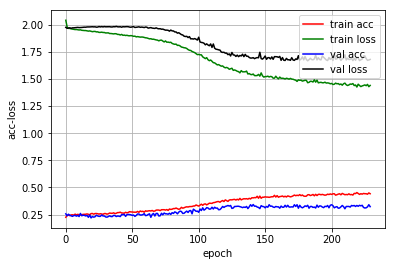

618/618 [==============================] - 0s 42us/step
test loss:  1.600496295586373
test accuracy:  0.36084142414111536


In [61]:
history.loss_plot('epoch')
loss_4, accuracy_4 = model.evaluate(test_x, test_y)
print('test loss: ', loss_4)
print('test accuracy: ', accuracy_4)

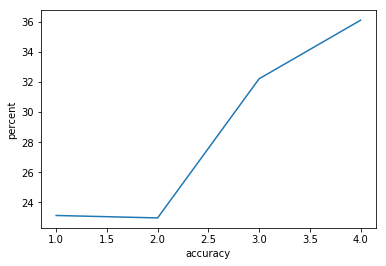

In [75]:
accuracy=[accuracy_1*100,accuracy_2*100,accuracy_3*100,accuracy_4*100]
number=[1,2,3,4]
plt.plot(number, accuracy)
plt.xlabel("accuracy")
plt.ylabel("percent")
plt.show()